In [8]:
import os

import pandas as pd
from tifffile import TiffFile
from ome_types import from_tiff, from_xml
# import seaborn as sns 
import numpy as np
import PIL
import matplotlib.pyplot as plt
from skimage.morphology import binary_closing
from skimage.measure import label, find_contours
from scipy.ndimage.morphology import binary_fill_holes
import scanpy as sc

In [9]:
import tifffile

In [5]:
adata = sc.read_h5ad('/data/multiplex/codex_inhouse/codex/HT206B1-H1/analysis/processed.h5ad')
adata

AnnData object with n_obs × n_vars = 175735 × 30
    obs: 'X', 'Y', 'leiden', 'cell type', 'row', 'col', 'annotated_tumor_region', 'unannotated_tumor_region', 'region_cell_count', 'unannotated_region_cell_count', 'tumor_region', 'tumor_region_cell_count'
    uns: 'MGP', 'annotated_tumor_region_tif', 'cell type_colors', 'cell_segmentation_tif', 'leiden', 'leiden_colors', 'neighbors', 'tumor_region_tif', 'umap', 'unannotated_tumor_region_tif'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [256]:
from skimage.morphology import disk
from skimage.filters import rank
def get_circular_gradient(radius):
    # https://stackoverflow.com/questions/55159007/plot-circular-gradients-using-numpy
    x_axis = np.linspace(-1, 1, radius)[:, None]
    y_axis = np.linspace(-1, 1, radius)[None, :]

    arr = np.sqrt(x_axis ** 2 + y_axis ** 2)
    
    inner = np.array([0, 0, 0])[None, None, :]
    outer = np.array([1, 1, 1])[None, None, :]

    arr /= arr.max()
    arr = arr[:, :, None]
    arr = arr * outer + (1 - arr) * inner
    
    return 1. - arr[:, :, 0]

def calculate_region_gradients(adata, marker_tif, radius=50, marker='MGP', mask_outer=True):
    regions = [int(x) for x in np.unique(adata.uns['tumor_region_tif']) if x!=0]
    fltr = get_circular_gradient(radius)
    gradient = np.zeros(marker_tif.shape)
    footprint = disk(radius)
    for region in regions:
        print(region)
        mask = adata.uns['tumor_region_tif']==region
        
        rs, cs = np.nonzero(mask)
        if len(rs) and len(cs):
            r1, r2 = min(rs), max(rs)
            c1, c2 = min(cs), max(cs)

            regional_mask = mask[r1:r2, c1:c2]
            if not mask_outer:
                regional_mask = np.full_like(regional_mask, True)
            
            regional_tif = marker_tif[r1:r2, c1:c2]
            regional_tif[~regional_mask] = 0.

            regional_gradient = rank.mean(regional_tif, footprint=footprint, mask=regional_mask)
            regional_gradient[~regional_mask] = 0.
            gradient[r1:r2, c1:c2] = gradient[r1:r2, c1:c2] + regional_gradient

    adata.uns[f'{marker}_gradient'] = gradient
    return adata

In [257]:
def find_edge_pixels(mask, thickness=2):
    pixels = []
    for r, c in np.argwhere(mask):
        diam = thickness // 2
        w = mask[max(r - diam, 0):r + 1 + diam, max(c - diam, 0):c + 1 + diam]
#         print(w, w.shape)
        if np.count_nonzero(~w) > 0:
            pixels.append([r, c])
    return np.asarray(pixels)


def score_region_boundaries(adata, marker_tif, radius=50, marker='MGP', thresh=.5, thickness=50, mask_outer=True):
    adata = calculate_region_gradients(adata, marker_tif, radius=radius, marker=marker)
    regions = [int(x) for x in np.unique(adata.uns['tumor_region_tif']) if x!=0]
    region_to_edge_mean_score, region_to_edge_breaks_score = {}, {}
    region_to_mean_score, region_to_breaks_score = {}, {}
    
    edge_mean_img = np.zeros(adata.uns['tumor_region_tif'].shape)
    edge_breaks_img = np.zeros(adata.uns['tumor_region_tif'].shape)
    mean_img = np.zeros(adata.uns['tumor_region_tif'].shape)
    breaks_img = np.zeros(adata.uns['tumor_region_tif'].shape)
    max_val = np.max(adata.uns[f'{marker}_gradient'])
    for region in regions:
        print(region)
        mask = adata.uns['tumor_region_tif']==region
        rs, cs = zip(*find_edge_pixels(mask, thickness=thickness))
        
        if len(rs):
        
            # mean 
            score = np.mean(adata.uns[f'{marker}_gradient'][rs, cs])
            edge_mean_img[rs, cs] = score
            region_to_edge_mean_score[region] = score

            score = np.mean(adata.uns[f'{marker}_gradient'][mask])
            mean_img[mask] = score
            region_to_mean_score[region] = score

            # breaks
            score = np.count_nonzero(adata.uns[f'{marker}_gradient'][rs, cs] < max_val * thresh) / len(rs)
            edge_breaks_img[rs, cs] = score
            region_to_edge_breaks_score[region] = score

            score = np.count_nonzero(adata.uns[f'{marker}_gradient'][mask] < max_val * thresh) / np.count_nonzero(mask)
            breaks_img[mask] = score
            region_to_breaks_score[region] = score

    adata.uns[f'edge_mean_{marker}_score_img'] = edge_mean_img
    adata.uns[f'region_to_edge_mean_{marker}_score'] = region_to_edge_mean_score
    adata.obs[f'region_edge_mean_{marker}_score'] = [region_to_edge_mean_score.get(r)
                                                     for r in adata.obs['tumor_region']]
    
    adata.uns[f'edge_breaks_{marker}_score_img'] = edge_breaks_img
    adata.uns[f'region_to_mean_{marker}_score'] = region_to_mean_score
    adata.obs[f'region_mean_{marker}_score'] = [region_to_mean_score.get(r)
                                                     for r in adata.obs['tumor_region']]
    
    adata.uns[f'mean_{marker}_score_img'] = mean_img
    adata.uns[f'region_to_edge_breaks_{marker}_score'] = region_to_edge_breaks_score
    adata.obs[f'region_edge_breaks_{marker}_score'] = [region_to_edge_breaks_score.get(r)
                                                     for r in adata.obs['tumor_region']]
    
    adata.uns[f'breaks_{marker}_score_img'] = breaks_img
    adata.uns[f'region_to_breaks_{marker}_score'] = region_to_breaks_score
    adata.obs[f'region_breaks_{marker}_score'] = [region_to_breaks_score.get(r)
                                                     for r in adata.obs['tumor_region']]
    
    return adata
        
        

In [212]:
# mask = adata.uns['tumor_region_tif']==10
# rs, cs = zip(*find_edge_pixels(mask, thickness=50))
# rs

In [213]:
adata = score_region_boundaries(adata, adata.uns['MGP'], radius=50, marker='MGP')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
myo = tifffile.imread('/data/multiplex/codex_inhouse/codex/HT206B1-H1/stiched/reg001_cyc005_ch003_Podoplanin.tif') + tifffile.imread('/data/multiplex/codex_inhouse/codex/HT206B1-H1/stiched/reg001_cyc008_ch002_SMA.tif')
adata = score_region_boundaries(adata, myo, radius=50, marker='Myoepithelial', thickness=50, mask_outer=False)





1


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65465), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


2


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65446), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


3


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65507), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


4


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (63548), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


5


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (63637), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


6


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (62769), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


7


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65415), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


8


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65314), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


9


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65535), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


10


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (63852), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


11


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (60474), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


12


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (64749), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


13


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65480), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


14


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (64988), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


15


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65536), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


16


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65353), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


17


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65467), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


18


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65350), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


19


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65359), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


20


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65375), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


21


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (63933), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


22


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (62587), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


23


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (58767), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


24


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65403), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


25


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (63619), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


26
27


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (61540), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


28


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (64491), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


29


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65534), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


30


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65286), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


31


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (61183), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


32


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65475), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


33


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (58044), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


34


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65489), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


35


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65397), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


36


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (34345), equivalent to an approximate bitdepth of 15.1.
  out_dtype)


37


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (7141), equivalent to an approximate bitdepth of 12.8.
  out_dtype)


38


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (45755), equivalent to an approximate bitdepth of 15.5.
  out_dtype)


39
40


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (61506), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


41


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (47175), equivalent to an approximate bitdepth of 15.5.
  out_dtype)


42


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (58751), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


43


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (54636), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


44


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (23290), equivalent to an approximate bitdepth of 14.5.
  out_dtype)


45


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (46866), equivalent to an approximate bitdepth of 15.5.
  out_dtype)


46


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (26753), equivalent to an approximate bitdepth of 14.7.
  out_dtype)


47


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (44642), equivalent to an approximate bitdepth of 15.4.
  out_dtype)


48


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (20898), equivalent to an approximate bitdepth of 14.4.
  out_dtype)


49


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (57906), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


50


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51132), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


51
52


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (18399), equivalent to an approximate bitdepth of 14.2.
  out_dtype)


53


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (38315), equivalent to an approximate bitdepth of 15.2.
  out_dtype)


54


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (59873), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


55


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (19609), equivalent to an approximate bitdepth of 14.3.
  out_dtype)


56


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (24392), equivalent to an approximate bitdepth of 14.6.
  out_dtype)


57


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (53262), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


58


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (42012), equivalent to an approximate bitdepth of 15.4.
  out_dtype)


59


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (27355), equivalent to an approximate bitdepth of 14.7.
  out_dtype)


60


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (55682), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


61


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (32437), equivalent to an approximate bitdepth of 15.0.
  out_dtype)


62


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (52227), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


63


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (49715), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


64


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (15929), equivalent to an approximate bitdepth of 14.0.
  out_dtype)


65


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (59227), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


66


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (58689), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


67


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5704), equivalent to an approximate bitdepth of 12.5.
  out_dtype)


68


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (48664), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


69


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (12002), equivalent to an approximate bitdepth of 13.6.
  out_dtype)


70


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (3863), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


71
72


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4256), equivalent to an approximate bitdepth of 12.1.
  out_dtype)


73


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (37880), equivalent to an approximate bitdepth of 15.2.
  out_dtype)


74


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (7262), equivalent to an approximate bitdepth of 12.8.
  out_dtype)


75


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (2167), equivalent to an approximate bitdepth of 11.1.
  out_dtype)


76


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (53626), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


77


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (14467), equivalent to an approximate bitdepth of 13.8.
  out_dtype)


78


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5248), equivalent to an approximate bitdepth of 12.4.
  out_dtype)


79


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (56721), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


80


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (54499), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


81


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (10523), equivalent to an approximate bitdepth of 13.4.
  out_dtype)


82


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (57097), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


83
84


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (56440), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


85
86


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (54725), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


87


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (45480), equivalent to an approximate bitdepth of 15.5.
  out_dtype)


88


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (64886), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


89


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (9588), equivalent to an approximate bitdepth of 13.2.
  out_dtype)


90


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (52262), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


91


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51513), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


92


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5062), equivalent to an approximate bitdepth of 12.3.
  out_dtype)


93
94
95


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (55146), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


96


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (52405), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


97


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (46387), equivalent to an approximate bitdepth of 15.5.
  out_dtype)


98


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (11692), equivalent to an approximate bitdepth of 13.5.
  out_dtype)


99


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (49665), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


100


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5603), equivalent to an approximate bitdepth of 12.5.
  out_dtype)


101


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (23241), equivalent to an approximate bitdepth of 14.5.
  out_dtype)


102


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (65138), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


103


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (36730), equivalent to an approximate bitdepth of 15.2.
  out_dtype)


104


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (39495), equivalent to an approximate bitdepth of 15.3.
  out_dtype)


105


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (14157), equivalent to an approximate bitdepth of 13.8.
  out_dtype)


106


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5759), equivalent to an approximate bitdepth of 12.5.
  out_dtype)


107


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (19533), equivalent to an approximate bitdepth of 14.3.
  out_dtype)


108


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (16707), equivalent to an approximate bitdepth of 14.0.
  out_dtype)


109


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (12717), equivalent to an approximate bitdepth of 13.6.
  out_dtype)


110


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (24305), equivalent to an approximate bitdepth of 14.6.
  out_dtype)


111


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (57649), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


112


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (49739), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


113


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (54656), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


114


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (39392), equivalent to an approximate bitdepth of 15.3.
  out_dtype)


115


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (22027), equivalent to an approximate bitdepth of 14.4.
  out_dtype)


116


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (15702), equivalent to an approximate bitdepth of 13.9.
  out_dtype)


117


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51704), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


118
119


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (32551), equivalent to an approximate bitdepth of 15.0.
  out_dtype)


120


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (46381), equivalent to an approximate bitdepth of 15.5.
  out_dtype)


121


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (29614), equivalent to an approximate bitdepth of 14.9.
  out_dtype)


122


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (6762), equivalent to an approximate bitdepth of 12.7.
  out_dtype)


123


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (64341), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


124


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (22639), equivalent to an approximate bitdepth of 14.5.
  out_dtype)


125


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (39117), equivalent to an approximate bitdepth of 15.3.
  out_dtype)


126


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (59596), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


127


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51883), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


128


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (13550), equivalent to an approximate bitdepth of 13.7.
  out_dtype)


129


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4821), equivalent to an approximate bitdepth of 12.2.
  out_dtype)


130


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (56871), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


131


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (57053), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


132
133


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (18997), equivalent to an approximate bitdepth of 14.2.
  out_dtype)


134


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (57220), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


135


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (57819), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


136


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (49890), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


137


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4096), equivalent to an approximate bitdepth of 12.0.
  out_dtype)


138


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (22611), equivalent to an approximate bitdepth of 14.5.
  out_dtype)


139


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (50188), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


140


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (18729), equivalent to an approximate bitdepth of 14.2.
  out_dtype)


141


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (29509), equivalent to an approximate bitdepth of 14.8.
  out_dtype)


142


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4346), equivalent to an approximate bitdepth of 12.1.
  out_dtype)


143


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (26627), equivalent to an approximate bitdepth of 14.7.
  out_dtype)


144


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (54626), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


145


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (8215), equivalent to an approximate bitdepth of 13.0.
  out_dtype)


146


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (44053), equivalent to an approximate bitdepth of 15.4.
  out_dtype)


147


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (53098), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


148


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (23609), equivalent to an approximate bitdepth of 14.5.
  out_dtype)


149


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (64496), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


150
151


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (20828), equivalent to an approximate bitdepth of 14.3.
  out_dtype)


152


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (10195), equivalent to an approximate bitdepth of 13.3.
  out_dtype)


153


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (21825), equivalent to an approximate bitdepth of 14.4.
  out_dtype)


154


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (9508), equivalent to an approximate bitdepth of 13.2.
  out_dtype)


155


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (14162), equivalent to an approximate bitdepth of 13.8.
  out_dtype)


156
157


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (36483), equivalent to an approximate bitdepth of 15.2.
  out_dtype)


158


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (46549), equivalent to an approximate bitdepth of 15.5.
  out_dtype)


159


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (58931), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


160


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (31110), equivalent to an approximate bitdepth of 14.9.
  out_dtype)


161


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (19288), equivalent to an approximate bitdepth of 14.2.
  out_dtype)


162


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (35430), equivalent to an approximate bitdepth of 15.1.
  out_dtype)


163


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (8954), equivalent to an approximate bitdepth of 13.1.
  out_dtype)


164


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (49465), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


165


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5410), equivalent to an approximate bitdepth of 12.4.
  out_dtype)


166


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (58638), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


167


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (50855), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


168


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (27734), equivalent to an approximate bitdepth of 14.8.
  out_dtype)


169
170


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (24165), equivalent to an approximate bitdepth of 14.6.
  out_dtype)


171


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (53510), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


172


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (42096), equivalent to an approximate bitdepth of 15.4.
  out_dtype)


173


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (7291), equivalent to an approximate bitdepth of 12.8.
  out_dtype)


174


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (53549), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


175


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (6831), equivalent to an approximate bitdepth of 12.7.
  out_dtype)


176


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (6068), equivalent to an approximate bitdepth of 12.6.
  out_dtype)


177


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (27514), equivalent to an approximate bitdepth of 14.7.
  out_dtype)


178


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5679), equivalent to an approximate bitdepth of 12.5.
  out_dtype)


179


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (24241), equivalent to an approximate bitdepth of 14.6.
  out_dtype)


180


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (22552), equivalent to an approximate bitdepth of 14.5.
  out_dtype)


181


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4815), equivalent to an approximate bitdepth of 12.2.
  out_dtype)


182


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (31875), equivalent to an approximate bitdepth of 15.0.
  out_dtype)


183


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (56207), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


184


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (52437), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


185


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (21920), equivalent to an approximate bitdepth of 14.4.
  out_dtype)


186


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (54587), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


187


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (20007), equivalent to an approximate bitdepth of 14.3.
  out_dtype)


188


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (9192), equivalent to an approximate bitdepth of 13.2.
  out_dtype)


189


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51747), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


190


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51668), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


191


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (53123), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


192


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4261), equivalent to an approximate bitdepth of 12.1.
  out_dtype)


193


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (19433), equivalent to an approximate bitdepth of 14.2.
  out_dtype)


194
195
196


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (55583), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


197


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (49306), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


198


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (56996), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


199
200


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5557), equivalent to an approximate bitdepth of 12.4.
  out_dtype)


201


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (30223), equivalent to an approximate bitdepth of 14.9.
  out_dtype)


202
203


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4726), equivalent to an approximate bitdepth of 12.2.
  out_dtype)


204


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (34469), equivalent to an approximate bitdepth of 15.1.
  out_dtype)


205
206


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (55020), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


207


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5330), equivalent to an approximate bitdepth of 12.4.
  out_dtype)


208


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4183), equivalent to an approximate bitdepth of 12.0.
  out_dtype)


209


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4890), equivalent to an approximate bitdepth of 12.3.
  out_dtype)


210


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4551), equivalent to an approximate bitdepth of 12.2.
  out_dtype)


211


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (23291), equivalent to an approximate bitdepth of 14.5.
  out_dtype)


212


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (6299), equivalent to an approximate bitdepth of 12.6.
  out_dtype)


213


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (15682), equivalent to an approximate bitdepth of 13.9.
  out_dtype)


214


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (38065), equivalent to an approximate bitdepth of 15.2.
  out_dtype)


215


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (59280), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


216
217


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4059), equivalent to an approximate bitdepth of 12.0.
  out_dtype)


218


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (8625), equivalent to an approximate bitdepth of 13.1.
  out_dtype)


219


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (17773), equivalent to an approximate bitdepth of 14.1.
  out_dtype)


220


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (9265), equivalent to an approximate bitdepth of 13.2.
  out_dtype)


221


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (41497), equivalent to an approximate bitdepth of 15.3.
  out_dtype)


222


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (6824), equivalent to an approximate bitdepth of 12.7.
  out_dtype)


223


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (16155), equivalent to an approximate bitdepth of 14.0.
  out_dtype)


224


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (34145), equivalent to an approximate bitdepth of 15.1.
  out_dtype)


225


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (7274), equivalent to an approximate bitdepth of 12.8.
  out_dtype)


226


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (63575), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


227


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51402), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


228


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (60344), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


229


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (54204), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


230


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (7715), equivalent to an approximate bitdepth of 12.9.
  out_dtype)


231


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (8605), equivalent to an approximate bitdepth of 13.1.
  out_dtype)


232


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (33228), equivalent to an approximate bitdepth of 15.0.
  out_dtype)


233
234


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (17662), equivalent to an approximate bitdepth of 14.1.
  out_dtype)


235


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (8994), equivalent to an approximate bitdepth of 13.1.
  out_dtype)


236
237


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51161), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


238


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (64592), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


239


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4556), equivalent to an approximate bitdepth of 12.2.
  out_dtype)


240


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (12877), equivalent to an approximate bitdepth of 13.7.
  out_dtype)


241


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (7636), equivalent to an approximate bitdepth of 12.9.
  out_dtype)


242


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (3721), equivalent to an approximate bitdepth of 11.9.
  out_dtype)


243


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (14734), equivalent to an approximate bitdepth of 13.8.
  out_dtype)


244


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (4323), equivalent to an approximate bitdepth of 12.1.
  out_dtype)


245


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (46768), equivalent to an approximate bitdepth of 15.5.
  out_dtype)


246


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (50618), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


247


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51274), equivalent to an approximate bitdepth of 15.6.
  out_dtype)


248


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (5210), equivalent to an approximate bitdepth of 12.3.
  out_dtype)


249


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (3291), equivalent to an approximate bitdepth of 11.7.
  out_dtype)


250


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (52390), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


251


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (52882), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


252


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (8176), equivalent to an approximate bitdepth of 13.0.
  out_dtype)


253


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (52973), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


254


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (51658), equivalent to an approximate bitdepth of 15.7.
  out_dtype)


255


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (57032), equivalent to an approximate bitdepth of 15.8.
  out_dtype)


256
257


/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (20075), equivalent to an approximate bitdepth of 14.3.
  out_dtype)


258
259


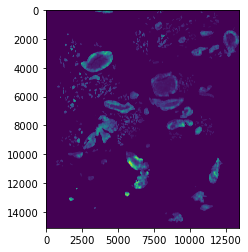

In [217]:
plt.imshow(adata.uns[f'MGP_gradient'])

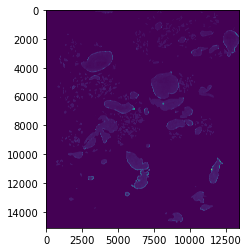

In [218]:
plt.imshow(adata.uns[f'Myoepithelial_gradient'])

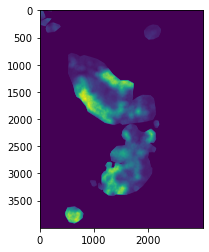

In [194]:
plt.imshow(adata.uns[f'MGP_gradient'][9000:13000, 5000:8000])

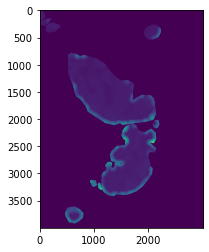

In [219]:
plt.imshow(adata.uns[f'Myoepithelial_gradient'][9000:13000, 5000:8000])

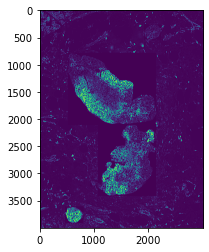

In [220]:
plt.imshow(adata.uns[f'MGP'][9000:13000, 5000:8000])

In [221]:
adata.uns.keys()

dict_keys(['MGP', 'annotated_tumor_region_tif', 'cell type_colors', 'cell_segmentation_tif', 'leiden', 'leiden_colors', 'neighbors', 'tumor_region_tif', 'umap', 'unannotated_tumor_region_tif', 'MGP_gradient', 'region_to_MGP_score', 'MGP_score_img', 'edge_mean_MGP_score_img', 'region_to_edge_mean_MGP_score', 'edge_breaks_MGP_score_img', 'region_to_mean_MGP_score', 'mean_MGP_score_img', 'region_to_edge_breaks_MGP_score', 'breaks_MGP_score_img', 'region_to_breaks_MGP_score', 'Myoepithelial_gradient', 'edge_mean_Myoepithelial_score_img', 'region_to_edge_mean_Myoepithelial_score', 'edge_breaks_Myoepithelial_score_img', 'region_to_mean_Myoepithelial_score', 'mean_Myoepithelial_score_img', 'region_to_edge_breaks_Myoepithelial_score', 'breaks_Myoepithelial_score_img', 'region_to_breaks_Myoepithelial_score'])

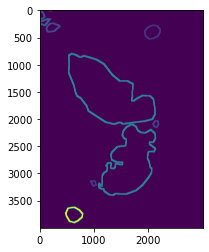

In [222]:
plt.imshow(adata.uns[f'edge_mean_MGP_score_img'][9000:13000, 5000:8000])

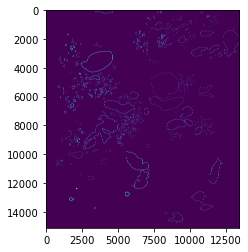

In [223]:
plt.imshow(adata.uns[f'edge_mean_MGP_score_img'])

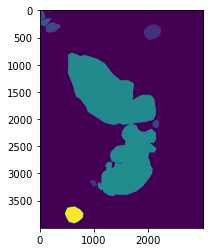

In [224]:
plt.imshow(adata.uns[f'mean_MGP_score_img'][9000:13000, 5000:8000])

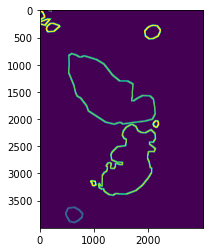

In [225]:
plt.imshow(adata.uns[f'edge_breaks_MGP_score_img'][9000:13000, 5000:8000])

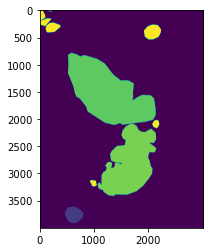

In [226]:
plt.imshow(adata.uns[f'breaks_MGP_score_img'][9000:13000, 5000:8000])

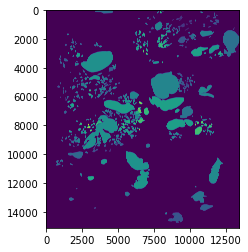

In [227]:
plt.imshow(adata.uns[f'MGP_score_img'])

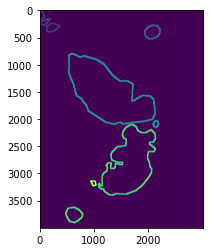

In [229]:
plt.imshow(adata.uns[f'edge_mean_Myoepithelial_score_img'][9000:13000, 5000:8000])

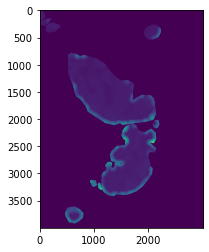

In [231]:
plt.imshow(adata.uns[f'Myoepithelial_gradient'][9000:13000, 5000:8000])

plot gradient correlations

In [235]:
mask = adata.uns['edge_mean_MGP_score_img']>0
mgp_pixels = adata.uns['MGP_gradient'][mask]
myo_pixels = adata.uns['Myoepithelial_gradient'][mask]
len(mgp_pixels)

8432852

In [241]:
# randomly correlate n pixels

from scipy.stats import pearsonr

coef, p_value = pearsonr(mgp_pixels, myo_pixels)
print(coef, p_value)




0.29065818275252714 0.0


<AxesSubplot:>

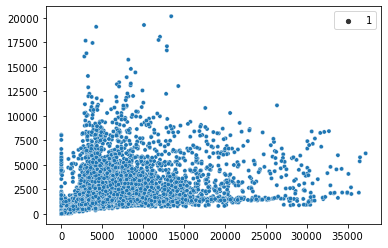

In [255]:
idxs = np.random.choice(np.arange(len(mgp_pixels)), size=10000)
sns.scatterplot(x=mgp_pixels[idxs], y=myo_pixels[idxs], size=1)

In [246]:
labels = np.unique(adata.uns['tumor_region_tif'][adata.uns['tumor_region_tif']>0])
data = []
for l in labels:
    x, y = adata.uns['region_to_edge_mean_MGP_score'].get(l), adata.uns['region_to_edge_mean_Myoepithelial_score'].get(l)
    if x is not None and y is not None:
        data.append([x, y])
        
df = pd.DataFrame(data=data, columns=['MGP_score', 'Myoepithelial_score'])
df
        

,MGP_score,Myoepithelial_score
0,10108.433541,1349.940158
1,7105.925362,1927.787504
2,5456.223731,3851.325244
3,5489.578682,1532.114359
4,5674.435563,1625.830671
...,...,...
466,2273.576263,918.391532
467,4543.680091,1045.187184
468,7219.575120,914.045408
469,5960.711886,1195.519757


<AxesSubplot:xlabel='MGP_score', ylabel='Myoepithelial_score'>

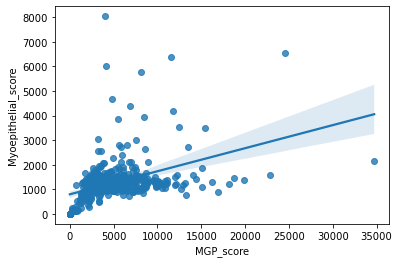

In [248]:
sns.regplot(data=df, x='MGP_score', y='Myoepithelial_score')

In [ ]:
plt.imshow(adata.uns[f'MGP_score_img'][9000:13000, 5000:8000])

In [228]:
adata.write_h5ad('/data/multiplex/codex_inhouse/codex/HT206B1-H1/analysis/processed_with_scores.h5ad')
# adata

/data/estorrs/miniconda3/envs/imaging_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

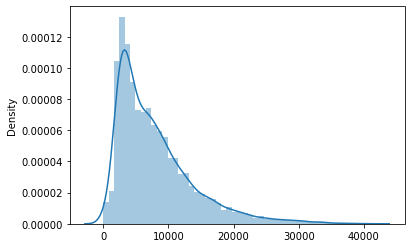

In [178]:
xs = [x for x in adata.uns['MGP_gradient'].flatten() if x != 0]
sns.distplot(np.random.choice(xs, size=10000))
# plt.xlim((0, 5000))

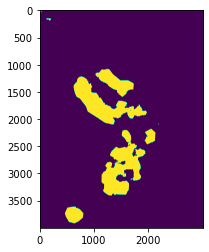

In [186]:
plt.imshow(adata.uns[f'MGP_gradient'][9000:13000, 5000:8000]>np.max(adata.uns[f'MGP_gradient']) * .25)

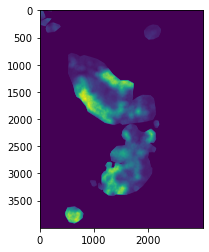

In [180]:
plt.imshow(adata.uns[f'MGP_gradient'][9000:13000, 5000:8000])

In [3]:
img = tifffile.imread('/data/multiplex/codex_inhouse/codex/HT206B1-H1/exports/annotation_mask.tif')
img.shape

(15120, 13440)

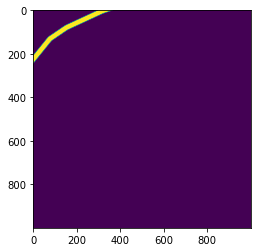

In [5]:
plt.imshow(img[3000:4000, 3000:4000])

In [6]:
np.max(img)

True

In [8]:
labeled = label(img)


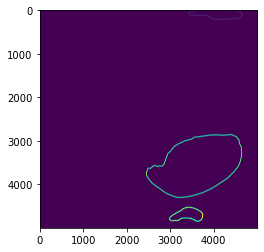

In [9]:
plt.imshow(labeled[:5000, :5000])

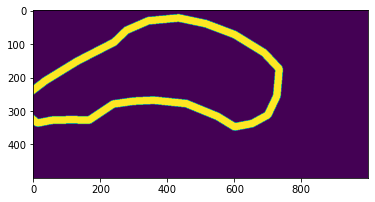

In [10]:
plt.imshow(labeled[4500:5000, 3000:4000])

In [12]:
np.unique(labeled)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35], dtype=int32)

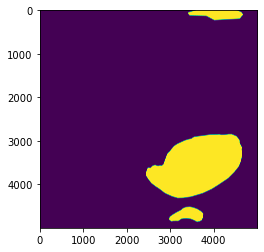

In [14]:
filled = binary_fill_holes(img)
plt.imshow(filled[:5000, :5000])

In [15]:
labeled = label(filled)


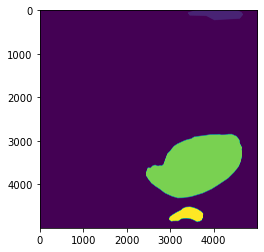

In [16]:
plt.imshow(labeled[:5000, :5000])

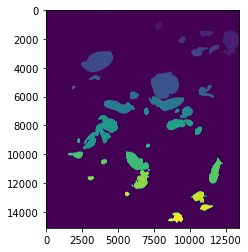

In [17]:
plt.imshow(labeled)